In [1]:
import pandas as pd
import dill

In [2]:
# Read csv file and create list of data
df = pd.read_csv('./data/train.csv', sep=";", engine='python')
df = df.sort_values(by=['REF_DECOMPTE', 'NUM_LIGNE_DECOMPTE'], ignore_index=True)

all_sequences = []
expected_values = []

hist_ref = df['REF_DECOMPTE'][0]
current_seq = []

for idx, row in df.iterrows():
    if row['REF_DECOMPTE'] == hist_ref:
        current_seq.append(row['CODE_ACTE'])
    else:
        if len(current_seq) > 2:
            all_sequences.append(current_seq[:-1]) # remove last item... to be predicted
            expected_values.append(current_seq[-1])

        current_seq = []
        hist_ref = row['REF_DECOMPTE']
        current_seq.append(row['CODE_ACTE'])

In [13]:
len(all_sequences)

950

In [14]:
my_cpt = dill.load(open('my_cpt.pkl', 'rb'))

In [15]:
target = all_sequences[:]
t_result = expected_values[:]

In [16]:
%time result = my_cpt.predict(target, n=2)

Wall time: 627 ms


In [17]:
result_c = [x[0] for x in result]

In [18]:
ndf = pd.DataFrame(data={'Prefix':target,'Real':t_result,'Full_Pred':result,'Pred':result_c})

In [19]:
accuracy = (ndf['Real']==ndf['Pred']).sum()/ndf.shape[0] * 100
print("%.2f %% of good predictions !" % accuracy)

71.37 % of good predictions !


In [20]:
ok = []
for idx,row in ndf.iterrows():
#     print(row.Real in row.Full_Pred)
    if row.Real in row.Full_Pred:
        ok.append(idx)
        
# accuracy = (ndf['Real'] in ndf['Full_Pred']).sum()/ndf.shape[0] * 100
# print("%.2f %% of good predictions !" % accuracy)

In [21]:
accuracy = len(ok)/ndf.shape[0] * 100
print("%.2f %% in the 2 first predictions" % accuracy)

88.42 % in the 2 first predictions


In [22]:
ndf[(ndf['Real']==ndf['Pred'])==False]

,Prefix,Real,Full_Pred,Pred
7,"[PH7, PH7, HD7, HD7, FRH, HDR, HDR, HDA]",HDA,"[HDE, HDA]",HDE
15,"[PH7, HD7, FRH, HDR]",HDE,"[HDA, HDE]",HDA
16,"[PA, FPA]",PA,"[FPA, PA]",FPA
19,"[IFO, AMS, FRH, IFO, AMS, FRH, IFO, AMS, FRH]",IFO,"[HDR, FRH]",HDR
27,"[SDE-A, SDE-A, AXI-A]",SDE-A,"[AXI-A, ADIDA]",AXI-A
...,...,...,...,...
941,"[AMI, FRH]",MAU,"[HDR, FRH]",HDR
942,"[AMI, FRH]",MAU,"[HDR, FRH]",HDR
943,"[AMI, FRH]",MAU,"[HDR, FRH]",HDR
946,"[PH7, HD7, FRH, PH7, HD7, FRH, HDR]",HDE,"[HDA, HDE]",HDA


In [23]:
no_answer = (ndf['Pred']=='--NO-RESULT--').sum()/ndf.shape[0] * 100
print("%.2f %%  without answer" % no_answer)

0.00 %  without answer


In [24]:
conf_matr = pd.crosstab(ndf['Real'], ndf['Pred'], rownames=['True'], colnames=['Predicted'], margins=True)

In [25]:
conf_matr

Predicted,ADCDA,ADI-S,ADIDA,AMI,AMK,AMO,AMS,ATM-S,AXI-A,B,...,SDE-A,SF,TO,V01CA,VER4,VM1,VM3,VU3,XM03,All
True,,,,,,,,,,,,,,,,,,,,,
ADC-S,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
ADCDA,1,0,0,0,0,0,0,0,1,0,...,2,0,0,0,0,0,0,0,0,4
ADE,0,2,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,4
ADI-S,0,8,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,10
ADIDA,0,0,6,0,0,0,0,0,7,0,...,4,0,0,0,0,0,0,0,0,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VM3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,5,0,0,5
VU3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
XM03,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


In [31]:
conf_matr2 = conf_matr.copy()

# (conf_matr2['All']<10).sum()

threshold = 5

conf_matr3 = conf_matr2.loc[(conf_matr2['All']>threshold),:]

drop_col = []
for col,seri in conf_matr3.iteritems():
    if seri['All']<=threshold:
        drop_col.append(col)

conf_matr4 = conf_matr3.drop(columns=drop_col)
conf_matr4 = conf_matr4.drop(columns='All')
conf_matr4 = conf_matr4[conf_matr4.index != "All"]

In [32]:
conf_matr4

Predicted,ADI-S,ADIDA,AMO,AMS,ATM-S,AXI-A,FPA,FPROS,FRH,HDA,...,HONM,IC0-A,IF,IK,MCS,MD,MEP,MPC,NFP,SDE-A
True,,,,,,,,,,,,,,,,,,,,,
ADI-S,8,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ADIDA,0,6,0,0,0,7,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
AMS,0,0,0,9,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ATM-S,2,0,0,0,15,0,0,0,0,0,...,0,0,0,0,8,0,0,8,0,0
AXI-A,0,1,0,0,0,10,0,0,0,0,...,0,1,0,0,0,0,0,0,0,7
FPROS,0,0,0,0,0,0,0,13,0,0,...,0,0,0,0,0,0,0,0,0,0
FRH,0,0,2,33,0,0,0,0,6,0,...,0,0,0,0,0,0,0,0,0,0
HDA,0,0,0,0,0,0,0,0,0,92,...,0,0,0,0,0,0,0,0,0,0
HDE,0,0,0,0,0,0,0,0,1,45,...,0,0,0,0,0,0,0,0,0,0


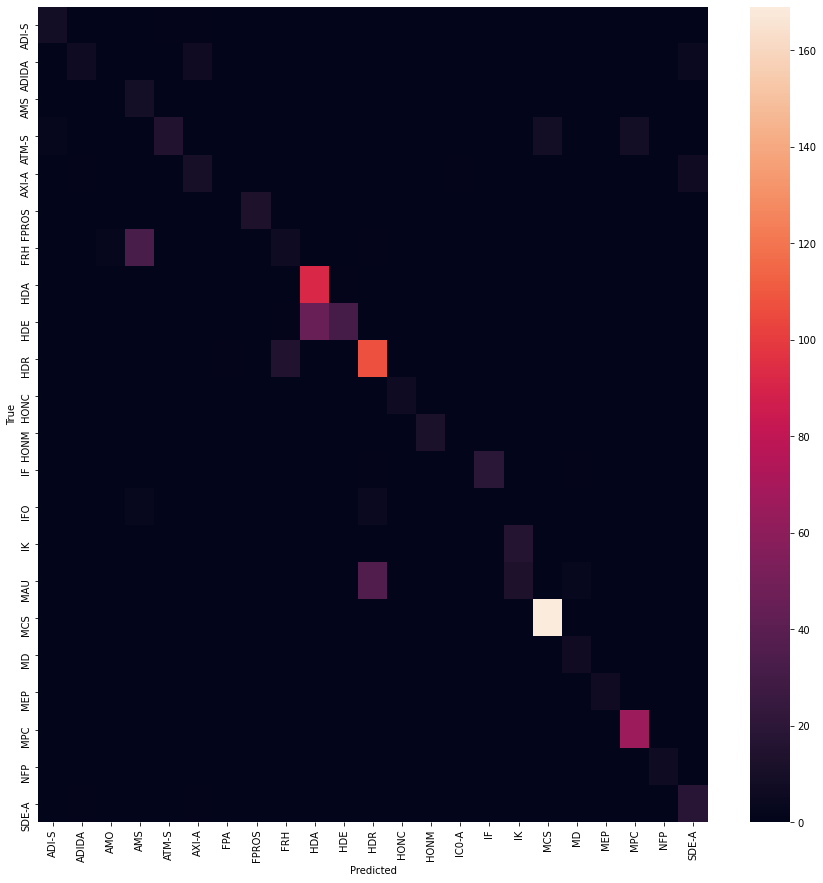

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 15]
sns.heatmap(conf_matr4)